In [28]:
import os
from os.path import join
from os import listdir
import pandas as pd
import numpy as np
import librosa
import librosa.display

from itertools import product

import IPython.display as ipd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from utils.main_utils import get_readers, get_chapters_info, collect_paths_with_meta

In [2]:
from typing import List, Tuple, Dict

In [3]:
audio_path = 'data/dev-clean/'

In [4]:
# Извлечем данные о дикторах
readers = get_readers('data/speakers.tsv', audio_path)
readers.head()

,GENDER,SUBSET,NAME
READER,,,
84,F,dev-clean,Christie Nowak
174,M,dev-clean,Peter Eastman
251,M,dev-clean,Mark Nelson
422,M,dev-clean,President Lethe
652,M,dev-clean,Scott Walter


In [5]:
# Извлечем данные о главах
chapter_info = get_chapters_info('./data/CHAPTERS.txt')
chapter_info.head()

,ID,READER,MINUTES,SUBSET,PROJ.,BOOK ID,CH. TITLE,PROJECT TITLE
0,1,110,19.77,train-other-500,53,1023,In Chancery,Bleak House
1,2,110,10.30,train-other-500,53,1023,In Fashion,Bleak House
2,159,4174,7.67,train-other-500,68,2184,Letter XXV,Unbeaten Tracks in Japan
3,198,19,8.42,train-clean-100,219,121,Chapter 01,Northanger Abbey
4,199,98,11.68,train-clean-360,219,121,Chapter 02,Northanger Abbey


In [6]:
# Посмоторим насколько сбалансированны данные по времени дорожек
readers.merge(chapter_info, on='READER')[['GENDER', 'MINUTES']].groupby('GENDER').sum()

,MINUTES
GENDER,
F,161.47
M,161.80


In [7]:
meta_paths = collect_paths_with_meta(audio_path, readers)
meta_paths.head()

,reader,gender,path
0,1919,F,data/dev-clean/1919/142785/1919_142785_000005_...
1,1919,F,data/dev-clean/1919/142785/1919_142785_000118_...
2,1919,F,data/dev-clean/1919/142785/1919_142785_000035_...
3,1919,F,data/dev-clean/1919/142785/1919_142785_000064_...
4,1919,F,data/dev-clean/1919/142785/1919_142785_000071_...


In [8]:
# Посмоторим насколько сбалансированны данные по количеству сэмплов
meta_paths.groupby('gender').count()

,reader,path
gender,,
F,2976,2976
M,2760,2760


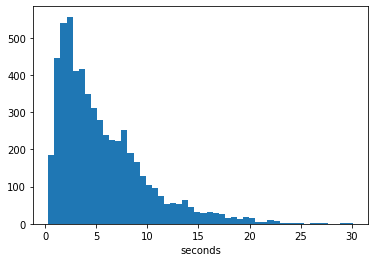

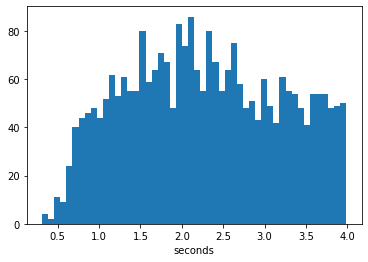

In [13]:
# Посмотрим на гистограмы распределения длительностей записей
durations = meta_paths.path.apply(lambda x: librosa.get_duration(filename=x))
plt.hist(durations,bins=50);
plt.xlabel('seconds');
plt.show()
plt.hist(durations[durations<4],bins=50);
plt.xlabel('seconds');

In [45]:
# Посмотрим, сколько данных потеряем, если выкинем дорожки короче 1, 2 и тд секунд
pd.DataFrame([(sec_per_window, len(meta_paths[durations>=sec_per_window])/len(meta_paths)) 
              for sec_per_window in range(1, 6)],
             columns = ['seconds', 'ratio'])

,seconds,ratio
0,1,0.958682
1,2,0.813110
2,3,0.662483
3,4,0.543061
4,5,0.447699


In [21]:
# Загрузим пример мужского и женского голоса
female_voice, sr = librosa.load(meta_paths[meta_paths.gender == 'F'].iloc[0].path)
male_voice, sr = librosa.load(meta_paths[meta_paths.gender == 'M'].iloc[0].path)

In [39]:
# Послушаем женский голос
ipd.Audio(female_voice, rate=sr)

In [23]:
# Послушаем мужской голос
ipd.Audio(male_voice, rate=sr)

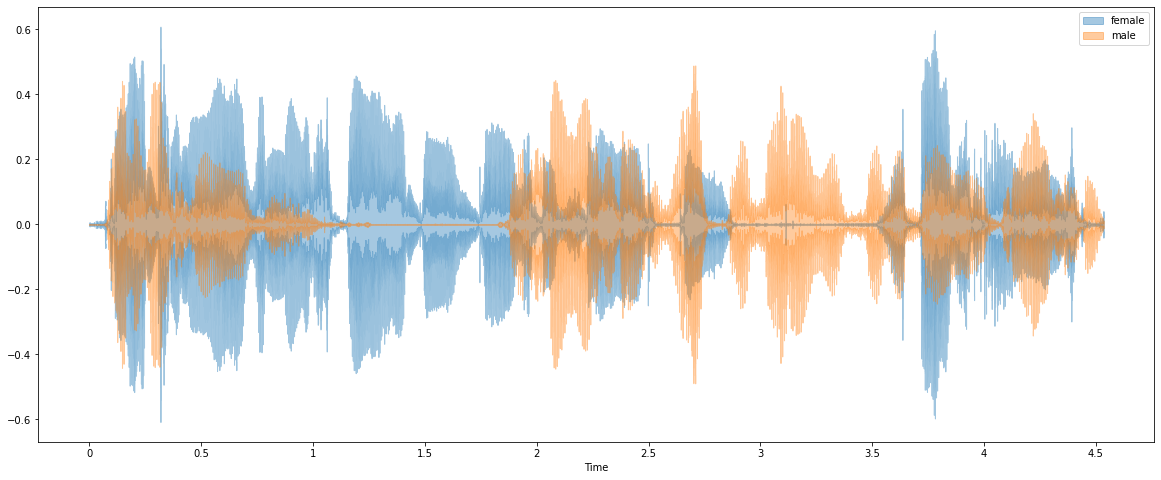

In [38]:
# Сравним вид сигналов голосов
fig, ax = plt.subplots(figsize=(20,8))
librosa.display.waveshow(female_voice[:100_000], sr=sr, alpha=0.4, ax=ax, label='female');
librosa.display.waveshow(male_voice[:100_000], sr=sr, alpha=0.4, ax=ax, label='male');
ax.legend()

Предоставленные данные сбалансированы по классу.
Существенная часть данных представленна в виде коротких отрезков записей.
Можно выдвинуть гипотезу о том, что важным признаком для решения задачи может отличие в высоте женского и мужского голоса.